In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as rmse
import pandas as pd
from progressbar import ProgressBar

import tensorflow as tf
from tensorflow import keras
from keras import backend as K
from tensorflow.keras.layers import Dense, Input, Conv1D, MaxPooling1D, Reshape, Flatten, GlobalMaxPooling1D, Layer
from tensorflow.keras.layers import Dropout, ReLU
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.losses import MeanSquaredError
from keras.initializers import glorot_normal
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

from tensorflow.keras import Model
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as rmse

from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import Sequential

from utils import *

In [2]:
np.random.seed(1)

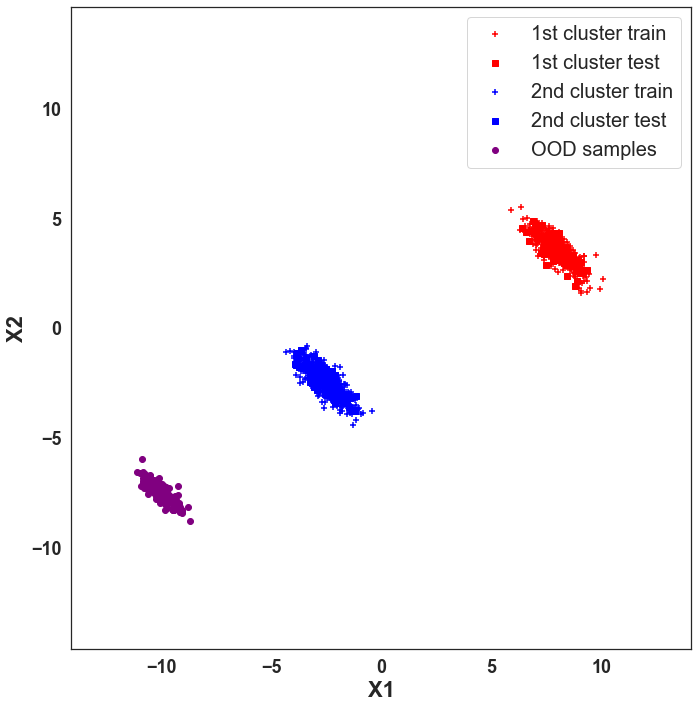

In [3]:
x_train, x_test, y_train, y_test, x_ood, y_ood, x_mesh, y_mesh = make_data()

In [4]:
scalerX, scalerY = MinMaxScaler(), MinMaxScaler()
x_train_norm, y_train_norm = scalerX.fit_transform(x_train), scalerY.fit_transform(y_train)
x_test_norm, y_test_norm = scalerX.transform(x_test), scalerY.transform(y_test)
x_ood_norm, y_ood_norm   = scalerX.transform(x_ood), scalerY.transform(y_ood)
x_mesh_norm = scalerX.transform(x_mesh)
y_mesh_norm = scalerY.transform(y_mesh.reshape(-1, 1))

## Gaussian Process Regression

In [5]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

model_GP = GaussianProcessRegressor(kernel=1 * RBF(length_scale=0.001, length_scale_bounds=(1e-3, 1e2)), 
                                    n_restarts_optimizer=10)
model_GP.fit(x_train_norm, y_train_norm)

C:\Users\Dell\AppData\Roaming\Python\Python39\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


GaussianProcessRegressor(kernel=1**2 * RBF(length_scale=0.001),
                         n_restarts_optimizer=10)

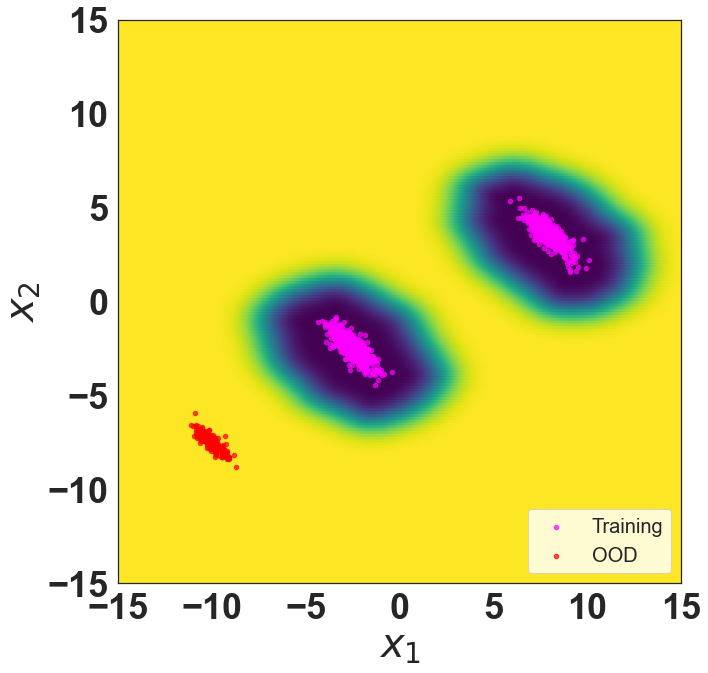

In [6]:
output, output_std = model_GP.predict(x_mesh_norm, return_std=True)
plot_uncertainty_map(x_train, x_ood, x_mesh, output_std, 'GP', False, False)

##### Calibration curve of GP

In [7]:
mean, std = model_GP.predict(x_mesh_norm, return_std=True)

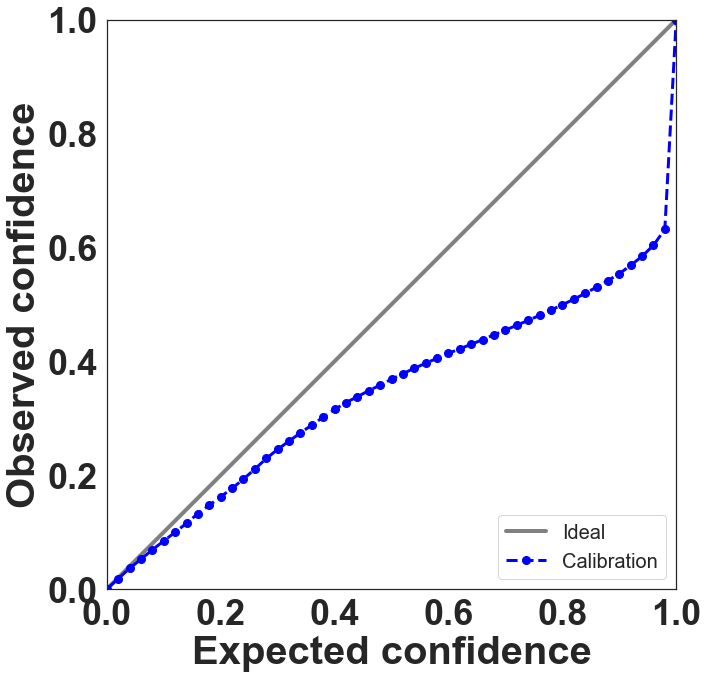

In [8]:
expected_confidences, observed_confidences = calculate_calibration(mean, std, y_mesh_norm)
plot_calibration_curve(expected_confidences, observed_confidences, 'GP')

##### MC Dropout for residual neural network

In [9]:
class DeepResNet(tf.keras.Model):
    """Defines a multi-layer residual network."""
    def __init__(self, num_classes, num_layers=3, num_hidden=128, dropout_rate=0.1):
        super().__init__()
        # Defines class meta data.
        self.num_hidden = num_hidden
        self.num_layers = num_layers
        self.dropout_rate = dropout_rate

        # Defines the hidden layers.
        self.input_layer = tf.keras.layers.Dense(self.num_hidden, activation = 'relu', trainable=False)
        
        self.dense_layers = [self.make_dense_layer() for _ in range(num_layers)]

        # Defines the output layer.
        self.regressor = self.make_output_layer(num_classes)

    def call(self, inputs):
        # Projects the 2d input data to high dimension.
        hidden = self.input_layer(inputs)

        # Computes the ResNet hidden representations.
        for i in range(self.num_layers):
            resid = self.dense_layers[i](hidden)
            resid = tf.keras.layers.Dropout(self.dropout_rate)(resid)
            hidden += resid

        return self.regressor(hidden)

    def make_dense_layer(self):
        """Uses the Dense layer as the hidden layer."""
        return tf.keras.layers.Dense(self.num_hidden, activation="relu", 
                                     kernel_initializer = tf.keras.initializers.glorot_normal())

    def make_output_layer(self, num_classes):
        """Uses the Dense layer as the output layer."""
        return tf.keras.layers.Dense(num_classes, activation=None)

In [10]:
resnet_config = dict(num_classes=1, num_layers=4, num_hidden=128)

In [11]:
resnet_model = DeepResNet(**resnet_config)

In [12]:
resnet_model.build((None, 2))
resnet_model.summary()

Model: "deep_res_net"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               multiple                  384       
                                                                 
 dense_1 (Dense)             multiple                  16512     
                                                                 
 dense_2 (Dense)             multiple                  16512     
                                                                 
 dense_3 (Dense)             multiple                  16512     
                                                                 
 dense_4 (Dense)             multiple                  16512     
                                                                 
 dense_5 (Dense)             multiple                  129       
                                                                 
Total params: 66,561
Trainable params: 66,177
Non-trai

In [13]:
optimizer = tf.keras.optimizers.Adam()
train_config = dict(loss='mean_squared_error', optimizer=optimizer)

In [14]:
fit_config = dict(batch_size=128, epochs=800)

In [15]:
resnet_model.compile(**train_config)
resnet_model.fit(x_train_norm, y_train_norm, **fit_config)

Train on 800 samples
Epoch 1/800
800/800 [==============================] - 1s 2ms/sample - loss: 0.0534
Epoch 2/800
800/800 [==============================] - 0s 13us/sample - loss: 0.0172
Epoch 3/800
800/800 [==============================] - 0s 43us/sample - loss: 0.0103
Epoch 4/800
800/800 [==============================] - 0s 12us/sample - loss: 0.0070
Epoch 5/800
800/800 [==============================] - 0s 41us/sample - loss: 0.0074
Epoch 6/800
800/800 [==============================] - 0s 19us/sample - loss: 0.0059
Epoch 7/800
800/800 [==============================] - 0s 36us/sample - loss: 0.0052
Epoch 8/800
800/800 [==============================] - 0s 24us/sample - loss: 0.0047
Epoch 9/800
800/800 [==============================] - 0s 36us/sample - loss: 0.0043
Epoch 10/800
800/800 [==============================] - 0s 20us/sample - loss: 0.0038
Epoch 11/800
800/800 [==============================] - 0s 35us/sample - loss: 0.0040
Epoch 12/800
800/800 [=====================

800/800 [==============================] - 0s 24us/sample - loss: 9.8281e-04
Epoch 97/800
800/800 [==============================] - 0s 32us/sample - loss: 9.9994e-04
Epoch 98/800
800/800 [==============================] - 0s 28us/sample - loss: 0.0010
Epoch 99/800
800/800 [==============================] - 0s 29us/sample - loss: 0.0011
Epoch 100/800
800/800 [==============================] - 0s 26us/sample - loss: 0.0011
Epoch 101/800
800/800 [==============================] - 0s 27us/sample - loss: 0.0012
Epoch 102/800
800/800 [==============================] - 0s 27us/sample - loss: 9.8599e-04
Epoch 103/800
800/800 [==============================] - 0s 28us/sample - loss: 9.2847e-04
Epoch 104/800
800/800 [==============================] - 0s 27us/sample - loss: 9.6695e-04
Epoch 105/800
800/800 [==============================] - 0s 28us/sample - loss: 0.0010
Epoch 106/800
800/800 [==============================] - 0s 32us/sample - loss: 9.6048e-04
Epoch 107/800
800/800 [=============

800/800 [==============================] - 0s 27us/sample - loss: 7.2415e-04
Epoch 187/800
800/800 [==============================] - 0s 16us/sample - loss: 7.4943e-04
Epoch 188/800
800/800 [==============================] - 0s 40us/sample - loss: 7.5639e-04
Epoch 189/800
800/800 [==============================] - 0s 16us/sample - loss: 9.0480e-04
Epoch 190/800
800/800 [==============================] - 0s 39us/sample - loss: 8.5961e-04
Epoch 191/800
800/800 [==============================] - 0s 22us/sample - loss: 9.6110e-04
Epoch 192/800
800/800 [==============================] - 0s 32us/sample - loss: 9.9702e-04
Epoch 193/800
800/800 [==============================] - 0s 26us/sample - loss: 7.4801e-04
Epoch 194/800
800/800 [==============================] - 0s 26us/sample - loss: 6.9120e-04
Epoch 195/800
800/800 [==============================] - 0s 27us/sample - loss: 7.5628e-04
Epoch 196/800
800/800 [==============================] - 0s 27us/sample - loss: 8.9740e-04
Epoch 197/800

800/800 [==============================] - 0s 47us/sample - loss: 4.6318e-04
Epoch 277/800
800/800 [==============================] - 0s 14us/sample - loss: 4.5475e-04
Epoch 278/800
800/800 [==============================] - 0s 44us/sample - loss: 4.5806e-04
Epoch 279/800
800/800 [==============================] - 0s 17us/sample - loss: 3.4851e-04
Epoch 280/800
800/800 [==============================] - 0s 39us/sample - loss: 4.0030e-04
Epoch 281/800
800/800 [==============================] - 0s 20us/sample - loss: 4.7418e-04
Epoch 282/800
800/800 [==============================] - 0s 36us/sample - loss: 5.1789e-04
Epoch 283/800
800/800 [==============================] - 0s 24us/sample - loss: 4.8119e-04
Epoch 284/800
800/800 [==============================] - 0s 32us/sample - loss: 3.9312e-04
Epoch 285/800
800/800 [==============================] - 0s 28us/sample - loss: 4.1768e-04
Epoch 286/800
800/800 [==============================] - 0s 30us/sample - loss: 3.7807e-04
Epoch 287/800

800/800 [==============================] - 0s 24us/sample - loss: 2.8014e-04
Epoch 367/800
800/800 [==============================] - 0s 34us/sample - loss: 2.5442e-04
Epoch 368/800
800/800 [==============================] - 0s 26us/sample - loss: 2.6627e-04
Epoch 369/800
800/800 [==============================] - 0s 33us/sample - loss: 2.6951e-04
Epoch 370/800
800/800 [==============================] - 0s 26us/sample - loss: 4.3649e-04
Epoch 371/800
800/800 [==============================] - 0s 33us/sample - loss: 2.8896e-04
Epoch 372/800
800/800 [==============================] - 0s 24us/sample - loss: 2.5539e-04
Epoch 373/800
800/800 [==============================] - 0s 34us/sample - loss: 2.6811e-04
Epoch 374/800
800/800 [==============================] - 0s 25us/sample - loss: 4.2300e-04
Epoch 375/800
800/800 [==============================] - 0s 35us/sample - loss: 3.5824e-04
Epoch 376/800
800/800 [==============================] - 0s 24us/sample - loss: 2.9282e-04
Epoch 377/800

800/800 [==============================] - 0s 24us/sample - loss: 1.3518e-04
Epoch 457/800
800/800 [==============================] - 0s 34us/sample - loss: 1.7570e-04
Epoch 458/800
800/800 [==============================] - 0s 29us/sample - loss: 1.4242e-04
Epoch 459/800
800/800 [==============================] - 0s 33us/sample - loss: 1.4934e-04
Epoch 460/800
800/800 [==============================] - 0s 29us/sample - loss: 1.2413e-04
Epoch 461/800
800/800 [==============================] - 0s 29us/sample - loss: 2.1336e-04
Epoch 462/800
800/800 [==============================] - 0s 29us/sample - loss: 1.3811e-04
Epoch 463/800
800/800 [==============================] - 0s 31us/sample - loss: 1.2042e-04
Epoch 464/800
800/800 [==============================] - 0s 18us/sample - loss: 1.8686e-04
Epoch 465/800
800/800 [==============================] - 0s 39us/sample - loss: 2.1776e-04
Epoch 466/800
800/800 [==============================] - 0s 14us/sample - loss: 1.8222e-04
Epoch 467/800

800/800 [==============================] - 0s 17us/sample - loss: 1.3036e-04
Epoch 547/800
800/800 [==============================] - 0s 43us/sample - loss: 1.3063e-04
Epoch 548/800
800/800 [==============================] - 0s 23us/sample - loss: 1.5960e-04
Epoch 549/800
800/800 [==============================] - 0s 37us/sample - loss: 1.2828e-04
Epoch 550/800
800/800 [==============================] - 0s 17us/sample - loss: 1.5845e-04
Epoch 551/800
800/800 [==============================] - 0s 43us/sample - loss: 1.6048e-04
Epoch 552/800
800/800 [==============================] - 0s 18us/sample - loss: 1.6384e-04
Epoch 553/800
800/800 [==============================] - 0s 41us/sample - loss: 3.3764e-04
Epoch 554/800
800/800 [==============================] - 0s 20us/sample - loss: 2.0866e-04
Epoch 555/800
800/800 [==============================] - 0s 40us/sample - loss: 1.9518e-04
Epoch 556/800
800/800 [==============================] - 0s 16us/sample - loss: 3.5736e-04
Epoch 557/800

800/800 [==============================] - 0s 34us/sample - loss: 1.9756e-04
Epoch 637/800
800/800 [==============================] - 0s 25us/sample - loss: 1.3350e-04
Epoch 638/800
800/800 [==============================] - 0s 35us/sample - loss: 1.9775e-04
Epoch 639/800
800/800 [==============================] - 0s 24us/sample - loss: 1.4698e-04
Epoch 640/800
800/800 [==============================] - 0s 34us/sample - loss: 1.3171e-04
Epoch 641/800
800/800 [==============================] - 0s 24us/sample - loss: 1.8225e-04
Epoch 642/800
800/800 [==============================] - 0s 34us/sample - loss: 2.2218e-04
Epoch 643/800
800/800 [==============================] - 0s 28us/sample - loss: 1.4602e-04
Epoch 644/800
800/800 [==============================] - 0s 32us/sample - loss: 1.1839e-04
Epoch 645/800
800/800 [==============================] - 0s 25us/sample - loss: 1.6865e-04
Epoch 646/800
800/800 [==============================] - 0s 36us/sample - loss: 1.3112e-04
Epoch 647/800

800/800 [==============================] - 0s 35us/sample - loss: 1.4344e-04
Epoch 727/800
800/800 [==============================] - 0s 28us/sample - loss: 1.0151e-04
Epoch 728/800
800/800 [==============================] - 0s 37us/sample - loss: 7.7174e-05
Epoch 729/800
800/800 [==============================] - 0s 20us/sample - loss: 9.9417e-05
Epoch 730/800
800/800 [==============================] - 0s 42us/sample - loss: 1.0697e-04
Epoch 731/800
800/800 [==============================] - 0s 31us/sample - loss: 1.2249e-04
Epoch 732/800
800/800 [==============================] - 0s 24us/sample - loss: 1.0863e-04
Epoch 733/800
800/800 [==============================] - 0s 34us/sample - loss: 1.0824e-04
Epoch 734/800
800/800 [==============================] - 0s 24us/sample - loss: 1.0906e-04
Epoch 735/800
800/800 [==============================] - 0s 35us/sample - loss: 8.2291e-05
Epoch 736/800
800/800 [==============================] - 0s 24us/sample - loss: 8.6975e-05
Epoch 737/800

In [16]:
niter = 40
MC_output = np.zeros((len(x_mesh), niter))
x_mesh_norm = scalerX.transform(x_mesh)

for i in range(niter):
    MC_output[:, i] = K.get_value(resnet_model(x_mesh_norm, training=True)).flatten()

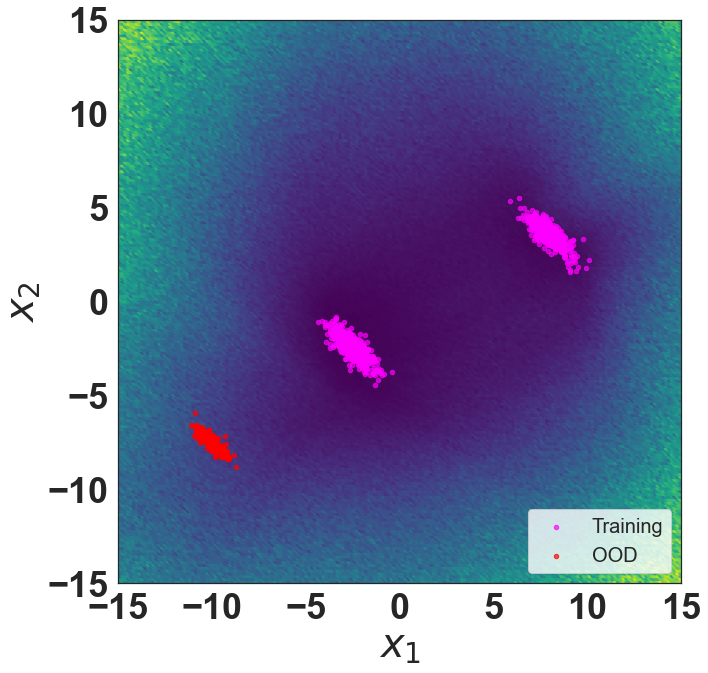

In [17]:
plot_uncertainty_map(x_train, x_ood, x_mesh, np.std(MC_output, axis = 1), 'MC_residual', False, False)

#### MC dropout for DNN

In [18]:
def DNN():
    model = Sequential([
        Dense(128, activation='relu'),
        Dropout(.1),
        Dense(128, activation='relu'),
        Dropout(.1),
        Dense(128, activation='relu'),
        Dropout(.1),
        Dense(128, activation='relu'),
        Dropout(.1),
        Dense(128, activation='relu'),
        Dropout(.1),
        Dense(128, activation='relu'),
        Dropout(.1),
        Dense(1, activation=None)
    ])

    return model

In [19]:
model = DNN()

In [20]:
optim = tf.keras.optimizers.Adam(1e-3)
model.compile(loss='mean_squared_error', optimizer = 'Adam')
model.fit(x_train_norm, y_train_norm, batch_size=128, epochs=1000, verbose=0)

In [21]:
niter = 40
MC_output = np.zeros((len(x_mesh), niter))

for i in range(niter):
    MC_output[:, i] = K.get_value(model(x_mesh_norm, training=True)).flatten()

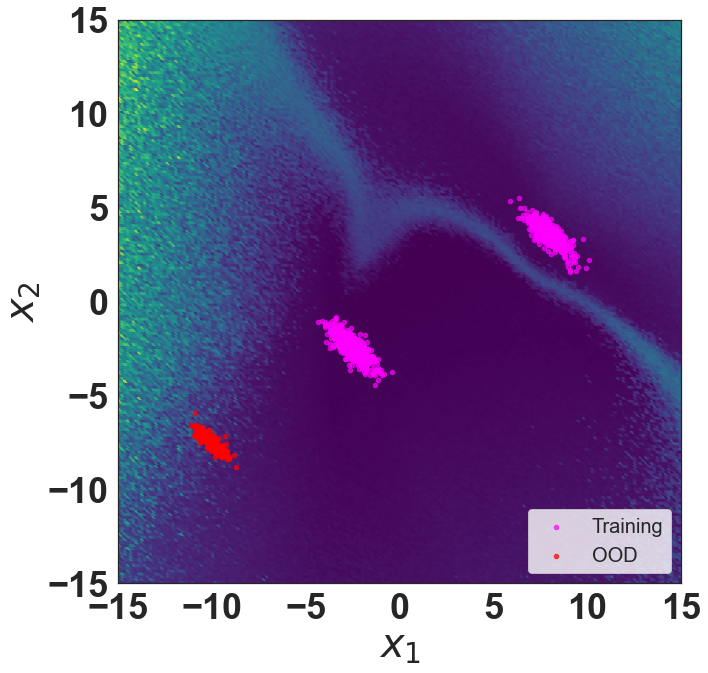

In [22]:
plot_uncertainty_map(x_train, x_ood, x_mesh, np.std(MC_output, axis = 1), 'MC', False, False)

###### Calibration curve of MC dropout for DNN

In [23]:
niter = 40
y_test_MC_output = np.zeros((len(x_mesh_norm), niter))

for i in range(niter):
    y_test_MC_output[:, i] = K.get_value(model(x_mesh_norm, training=True)).flatten()

In [24]:
mean, std = np.mean(y_test_MC_output, axis = 1), np.std(y_test_MC_output, axis = 1)

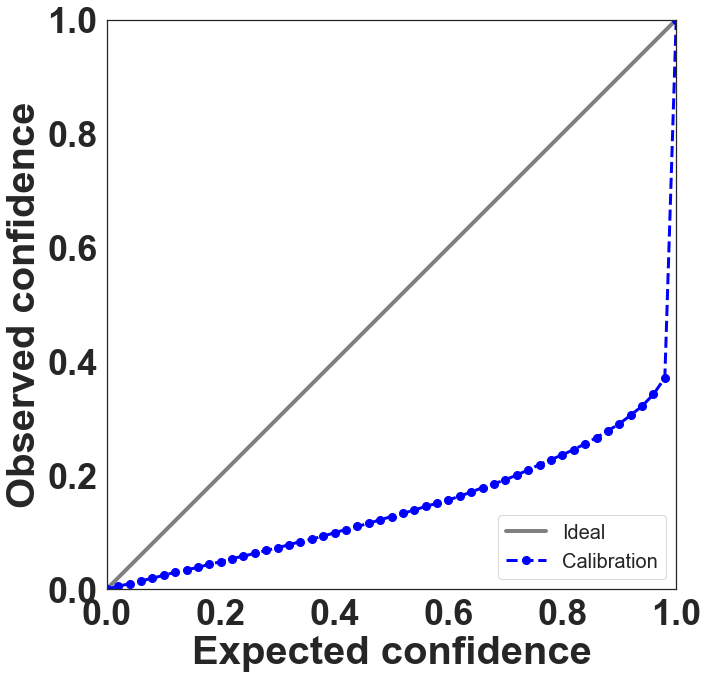

In [25]:
expected_confidences, observed_confidences = calculate_calibration(mean, std, y_mesh_norm)
plot_calibration_curve(expected_confidences, observed_confidences, 'MC')

## Deep Ensemble

In [26]:
# loss function and new custom layer to give mean and standard deviation
# Inspired from https://medium.com/@albertoarrigoni/paper-review-code-deep-ensembles-nips-2017-c5859070b8ce
def custom_loss(sigma):
    def gaussian_loss(y_true, y_pred):
        return tf.reduce_mean(0.5*tf.math.log((sigma)) + 0.5*tf.math.divide(tf.math.square(y_true - y_pred), (sigma))) + 1e-6
    return gaussian_loss

class GaussianLayer(Layer):
    def __init__(self, output_dim, **kwargs):
        self.output_dim = output_dim
        super(GaussianLayer, self).__init__(**kwargs)
        
    def build(self, input_shape):
        self.kernel_1 = self.add_weight(name='kernel_1', 
                                      shape=(10, self.output_dim),
                                      initializer=glorot_normal(),
                                      trainable=True)
        self.kernel_2 = self.add_weight(name='kernel_2', 
                                      shape=(10, self.output_dim),
                                      initializer=glorot_normal(),
                                      trainable=True)
        self.bias_1 = self.add_weight(name='bias_1',
                                    shape=(self.output_dim, ),
                                    initializer=glorot_normal(),
                                    trainable=True)
        self.bias_2 = self.add_weight(name='bias_2',
                                    shape=(self.output_dim, ),
                                    initializer=glorot_normal(),
                                    trainable=True)
        super(GaussianLayer, self).build(input_shape) 
        
    def call(self, x):
        output_mu  = K.dot(x, self.kernel_1) + self.bias_1
        output_sig = K.dot(x, self.kernel_2) + self.bias_2
        output_sig_pos = K.log(1 + K.exp(output_sig)) + 1e-06  
        return [output_mu, output_sig_pos]
    
    def compute_output_shape(self, input_shape):
        return [(input_shape[0], self.output_dim), (input_shape[0], self.output_dim)]

In [27]:
def generate_trained_DEmodel(trainX, trainY, nepochs, actfn = 'relu'):
    n_inp_features = np.shape(trainX)[1]
    feature_input = Input(shape=(n_inp_features,), name="feature_input_layer")
    x = Dense(128, activation = actfn)(feature_input)
    x = Dense(128, activation = actfn)(x)
    x = Dense(64, activation = actfn)(x)
    x = Dense(10, activation = actfn)(x)
    mu, sigma = GaussianLayer(1, name='main_output')(x)
    model = Model(feature_input, mu)
    model.compile(loss=custom_loss(sigma), optimizer='adam')
    model.fit(trainX, trainY, shuffle=False, epochs=nepochs, verbose = 0)
    
    layer_name = 'main_output' # Where to extract the Gaussian output from. 
    get_intermediate = K.function(inputs=[model.input], outputs=model.get_layer(layer_name).output)
    return get_intermediate

In [28]:
## Create 20 models and select some based on training error
prediction_fns, train_rmse = [], []
nmodels = 20
nepochs = 1000

pbar=ProgressBar()
for i in pbar(range(nmodels)):
    my_func = generate_trained_DEmodel(x_train_norm, y_train_norm, nepochs, actfn = 'relu')
    train_rmse.append(rmse(y_train_norm, my_func(x_train_norm)[0]))
    prediction_fns.append(my_func)

100% |########################################################################|


In [29]:
nmodels_select = 10
final_DE_fns = []
for i in range(nmodels_select):
    final_DE_fns.append(prediction_fns[np.argsort(train_rmse)[:nmodels_select][i]])

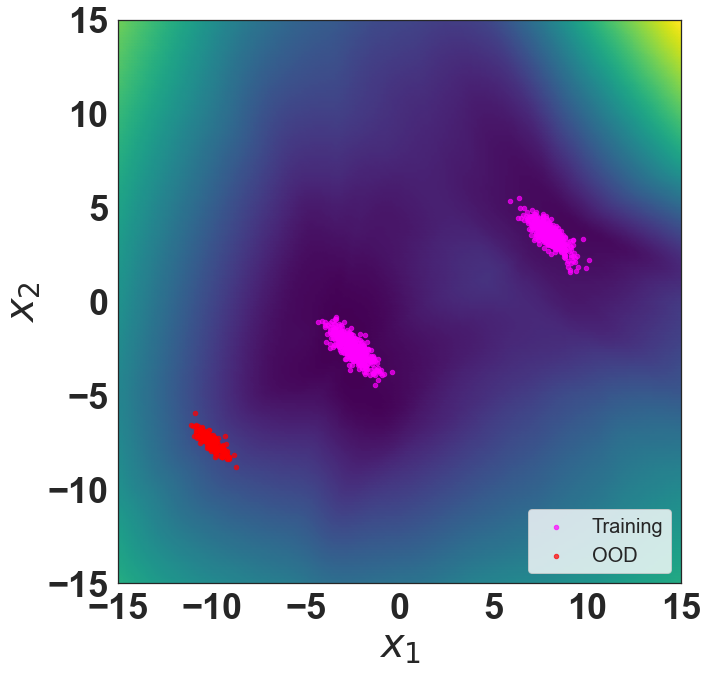

In [30]:
def get_ensemble(df, UQmodelcode, nmodels_select):
    mu_cols = [UQmodelcode + "_mu_"+str(i) for i in range(nmodels_select)]
    sigma_cols = [UQmodelcode + "_sigma_"+str(i) for i in range(nmodels_select)]
    
    mu_eff = df[mu_cols].mean(axis=1)
    sigma_eff =  np.sqrt(np.mean(df[mu_cols]**2, axis = 1)
                         + np.mean(df[sigma_cols]**2, axis = 1)
                         - mu_eff**2)
    df[UQmodelcode+"_mu_eff"] = mu_eff
    df[UQmodelcode+"_sigma_eff"] = sigma_eff
    return df

result_df = pd.DataFrame(x_mesh_norm, columns = ['x1', 'x2'])
for i in range(nmodels_select):
    result_df["DE_mu_"+str(i)] = final_DE_fns[i](x_mesh_norm)[0]
    result_df["DE_sigma_"+str(i)] = np.sqrt(final_DE_fns[i](x_mesh_norm)[1])

result_df = get_ensemble(result_df, "DE", nmodels_select)
plot_uncertainty_map(x_train, x_ood, x_mesh, result_df['DE_sigma_eff'], 'DE', False, False)

In [32]:
result_df = pd.DataFrame(x_mesh_norm, columns = ['x1', 'x2'])
for i in range(nmodels_select):
    result_df["DE_mu_"+str(i)] = final_DE_fns[i](x_mesh_norm)[0]
    result_df["DE_sigma_"+str(i)] = np.sqrt(final_DE_fns[i](x_mesh_norm)[1])

result_df = get_ensemble(result_df, "DE", nmodels_select)

In [33]:
mean, std = result_df['DE_mu_eff'], result_df['DE_sigma_eff']

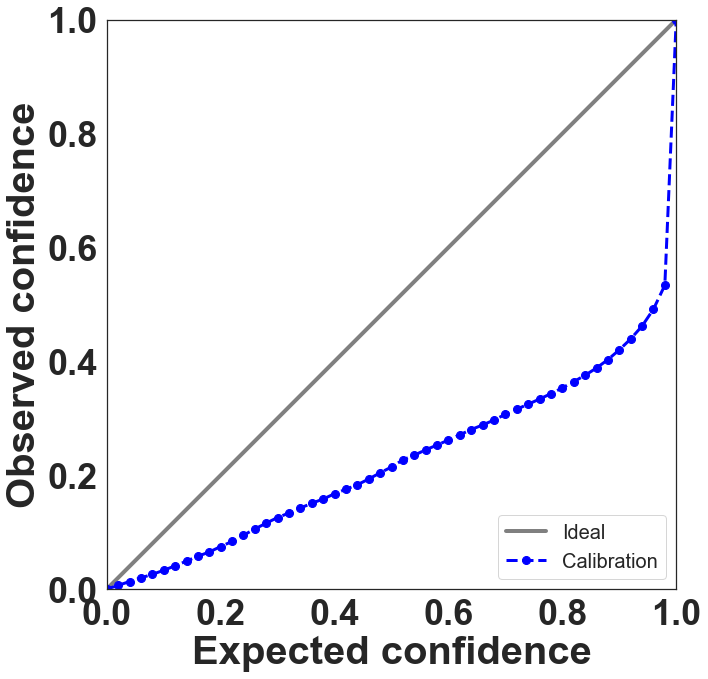

In [34]:
expected_confidences, observed_confidences = calculate_calibration(mean, std, y_mesh_norm)
plot_calibration_curve(expected_confidences, observed_confidences, 'DE')